In [2]:
import pandas as pd
import json
import matplotlib.pyplot as plt
import mmcv
import cv2
from collections import Counter
import numpy as np
import lap
import glob
import os
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

#### OCR

In [3]:
ocr = json.load(open('/media/data_disc/data/videos2/2021_01_20_Colorado_at_Washington/2021_01_20_Colorado_at_Washington_ocr.json'))

In [4]:
l = None
cnt = 0
for k, v in ocr['results'].items():
    if ocr['results'][k]['score_bug_present'] and ocr['results'][k]['game_clock_running']:
        cnt+=1
        l = k
print(cnt, len(ocr['results']), l)

69153 172920 170983


### Players Stats Main

In [5]:
csv_path = '/home/ubuntu/oljike/data/demo_vids/2020_11_28_TexasSouthern_at_OklahomaState/2020_11_28_TexasSouthern_at_OklahomaState_time.csv'
tracking_path = '/home/ubuntu/oljike/data/demo_vids/2020_11_28_TexasSouthern_at_OklahomaState/2020_11_28_TexasSouthern_at_OklahomaState_tracking.json'
ocr_path = '/home/ubuntu/oljike/data/demo_vids/2020_11_28_TexasSouthern_at_OklahomaState/2020_11_28_TexasSouthern_at_OklahomaState_ocr.json'

In [14]:
class PlayerStat():
    def __init__(self, csv_path, tracking_res, ocr_path):
        self.csv_path = csv_path
        self.ocr = json.load(open(ocr_path))
        self.pl_time = pd.read_csv(csv_path)
        self.tracking = json.load(open(tracking_res))
        print("Number of active frames ", len(self.tracking))
        
    def get_cnt(self,):
        
        
        team_1 = []
        team_2 = []
        cnt = 0
        for k, v in self.tracking.items():
            for el in v:
                curr_el = el.split(',')
                if curr_el[-2] == '0.0':
                    team_1.append(curr_el[-1])
                elif curr_el[-2] == '1.0':
                    team_2.append(curr_el[-1])
                cnt += 1

#         print("Team balance {} / {}".format(len(team_1), len(team_2)))
        cnt_1 = Counter(team_1)
        cnt_2 = Counter(team_2)
        
        return cnt_1, cnt_2
       
    
    def get_players(self,):

        pl_time = self.pl_time
        teams = pl_time['team'].unique()
        self.team_1 = teams[0]
        self.team_2 = teams[1]

        players1 = pl_time.loc[pl_time['team'] == teams[0]]['jersey_number'].tolist()
        players1 = set([str(x) for x in players1])

        players2 = pl_time.loc[pl_time['team'] == teams[1]]['jersey_number'].tolist()
        players2 = set([str(x) for x in players2])

        teams_dct = []
        teams_dct.append((players1, 0))
        teams_dct.append((players2, 1))


        return players1, players2, teams, teams_dct
        
    
    def remove_nonex(self, cnt, players1, players2):
    
        for k in list(cnt):
            if k=='None': 
                cnt.pop(k, 'None')
            elif k not in players1 and k not in players2:
                cnt.pop(k, 'None')

        return cnt

    
    def get_local_percentage(self, cnt, players, teams):
        if players in teams[0]:
            idx = teams[0][1]
        else:
            idx = teams[1][1]

        teams = self.pl_time['team'].unique()
        time_info = self.pl_time.loc[self.pl_time['team'] == teams[idx]][['minutes_int', 'jersey_number']]

        res = {}
        for row in time_info.iterrows():
            player = str(int(row[1][1]))

            if player in players:
                res[player] = str(round(100 * (cnt[player] / self.ocr['video_fps'] / 60) / float(row[1][0]), 2)) + '%'

        return {k: v for k, v in sorted(res.items(), key=lambda item: item[1], reverse=True)}

        
    def calc_hist_loss(self, cnt, players1, players2):
    
        max_ = max(list(cnt.values()))
        min_ = min(list(cnt.values()))
        loss_1 = 0
        loss_2 = 0
        for k, v in cnt.items():

            curr_val = (int(v) - min_)/(max_ - min_)       
            if k in players1 and k in players2:
                loss_1 += 1 - curr_val
                loss_2 += 1 - curr_val           
            elif (k) in players1 and (k) not in players2:
                loss_1 += 1 - curr_val
                loss_2 += 1
            elif (k) not in players1 and (k) in players2:
                loss_1 += 1
                loss_2 += 1 - curr_val
            elif (k) not in players1 and (k) not in players2:
                loss_1 += 1
                loss_2 += 1

        return loss_1, loss_2

    
    def get_cost(self, cnt1_l1, cnt1_l2, cnt2_l1, cnt2_l2):
        '''
        return: two tuples, each tuple is a match between jersey counter and player list from CSV file.
        cnt1 - means 0 in tracking file
        cnt2 - means 1 in tracking file
        
        pair1 - match between cn1 and eith players1 or players2
        pair2 - match between cn2 and eith players1 or players2
        '''
        
        cost_matrix = np.array([[cnt1_l1, cnt1_l2], [cnt2_l1, cnt2_l2]])
        matches, unmatched_a, unmatched_b = [], [], []
        cost, x, y = lap.lapjv(cost_matrix, extend_cost=True)
        for ix, mx in enumerate(x):
            if mx >= 0:
                matches.append([ix, mx])
        unmatched_a = np.where(x < 0)[0]
        unmatched_b = np.where(y < 0)[0]
        matches = np.asarray(matches)

        if matches[0][1] == 0:
            pair1 = (self.cnt_1, self.players1)
            pair2 = (self.cnt_2, self.players2)
            print('0 maps to ', self.team_1)
            print('1 maps to ', self.team_2)
            self.team_map = {'home': self.team_1, 'away': self.team_2}
            
        elif matches[0][1] == 1:
            pair1 = (self.cnt_1, self.players2)
            pair2 = (self.cnt_2, self.players1)
            print('0 maps to ', self.team_2)
            print('1 maps to ', self.team_1)
            self.team_map = {'home': self.team_2, 'away': self.team_1}

        
        return pair1, pair2


    def get_stats_percentage(self,): 
        
        players1, players2, teams, teams_dct  = self.get_players()
        self.players1 = players2
        self.players2 = players2
        
        cnt_1, cnt_2 = self.get_cnt()
        
        cnt_1 = self.remove_nonex(cnt_1, players1, players2)
        cnt_2 = self.remove_nonex(cnt_2, players1, players2)
        
        self.cnt_1 = cnt_1
        self.cnt_2 = cnt_2
        
        
        cnt1_l1, cnt1_l2 = self.calc_hist_loss(cnt_1, players1, players2)
        cnt2_l1, cnt2_l2 = self.calc_hist_loss(cnt_2, players1, players2)
        
        
        pair1, pair2 = self.get_cost(cnt1_l1, cnt1_l2, cnt2_l1, cnt2_l2)
        
        print('Results for ', self.csv_path.split('/')[-2])
        print('-'*50)
        percentage_dict = {}
        if pair1[1] in teams_dct[0]:
            output_1 = self.get_local_percentage(pair1[0], pair1[1], teams_dct)
            ouptut_2 = self.get_local_percentage(pair2[0], pair2[1], teams_dct)
            print(str(teams[0]), output_1)
            print(str(teams[1]), output_2) 
            percentage_dict[str(teams[0])] = output_1
            percentage_dict[str(teams[1])] = output_2
            
        elif pair1[1] in teams_dct[1]:
            output_1 = self.get_local_percentage(pair1[0], pair1[1], teams_dct)
            output_2 = self.get_local_percentage(pair2[0], pair2[1], teams_dct)
            
            print(str(teams[1]), output_1)
            print(str(teams[0]), output_2)  
            percentage_dict[str(teams[1])] = output_1
            percentage_dict[str(teams[0])] = output_2
            
        else: 
            print("No pairs found")
            
        self.percentage_dict = percentage_dict
        print('-'*50)

In [15]:
stat = PlayerStat(csv_path, tracking_path, ocr_path)
stat.get_stats_percentage()

Number of active frames  67997
0 maps to  Texas Southern
1 maps to  Oklahoma State
Results for  2020_11_28_TexasSouthern_at_OklahomaState
--------------------------------------------------
Texas Southern {'1': '85.29%', '11': '84.98%', '5': '76.4%', '15': '72.92%', '24': '67.7%', '14': '67.18%', '0': '67.17%', '20': '65.33%', '23': '56.04%', '33': '45.13%', '12': '40.1%', '2': '119.62%'}
Oklahoma State {'11': '9.24%', '0': '80.06%', '5': '63.31%', '2': '474.73%', '1': '47.16%', '20': '34.05%', '23': '33.09%', '14': '16.91%', '12': '126.56%', '24': '0.19%', '15': '0.02%', '33': '0.0%'}
--------------------------------------------------


In [16]:
stat.team_map

{0: 'Texas Southern', 1: 'Oklahoma State'}

In [10]:
all_games =glob.glob('./demos/custom_5vals_colors_all_30ep_data2_50ep/*')
for game in all_games:
    if not os.path.isdir(game): continue
        
    name = game.split('/')[-1]
    csv_path = os.path.join(game, name + '_time.csv')
    tracking_path = os.path.join(game, name + '.json')
    if 'orig' in name: 
        ocr_path = os.path.join('/media/data_disc/data/videos2/', name, name.replace('_orig', '') + '_ocr.json')
    else:
        ocr_path = os.path.join('/media/data_disc/data/videos2/', name, name + '_ocr.json')
    
    
    if not os.path.exists(ocr_path):
        if 'orig' in name: 
            ocr_path = os.path.join('/home/ubuntu/oljike/data/demo_vids/', name.replace('_orig', ''), name.replace('_orig', '') + '_ocr.json')
        else:
            ocr_path = os.path.join('/home/ubuntu/oljike/data/demo_vids/', name, name + '_ocr.json')
       
    stat = PlayerStat(csv_path, tracking_path, ocr_path)
    stat.get_stats_percentage()

Number of active frames  61812
Results for  2021_03_13_OklahomaState_at_Texas_orig
--------------------------------------------------
Texas {'2': '87.89%', '1': '75.7%', '4': '72.25%', '3': '66.61%', '30': '58.41%', '20': '57.52%', '13': '50.18%', '22': '42.52%'}
Oklahoma State {'13': '98.41%', '22': '87.89%', '1': '8.63%', '2': '77.12%', '30': '2.34%', '20': '10.8%', '4': '1.47%', '3': '1.31%'}
--------------------------------------------------
Number of active frames  67997
Results for  2020_11_28_TexasSouthern_at_OklahomaState_orig
--------------------------------------------------
Texas Southern {'1': '85.29%', '11': '84.98%', '5': '76.4%', '15': '72.92%', '24': '67.7%', '14': '67.18%', '0': '67.17%', '20': '65.33%', '23': '56.04%', '33': '45.13%', '12': '40.1%', '2': '119.62%'}
Oklahoma State {'11': '9.24%', '0': '80.06%', '5': '63.31%', '2': '474.73%', '1': '47.16%', '20': '34.05%', '23': '33.09%', '14': '16.91%', '12': '126.56%', '24': '0.19%', '15': '0.02%', '33': '0.0%'}
-----

In [11]:
tracking_path

'./demos/custom_5vals_colors_all_30ep_data2_50ep/2020_12_05_Oakland_at_OklahomaState/2020_12_05_Oakland_at_OklahomaState.json'

# Single functions

In [5]:
def get_players(pl_time):

#     players = pd.read_csv(path)
    
    teams = pl_time['team'].unique()
    
    players1 = pl_time.loc[pl_time['team'] == teams[0]]['jersey_number'].tolist()
    players1 = set([str(x) for x in players1])

    players2 = pl_time.loc[pl_time['team'] == teams[1]]['jersey_number'].tolist()
    players2 = set([str(x) for x in players2])
    
    teams_dct = []
    teams_dct.append((players1, 0))
    teams_dct.append((players2, 1))
    
    
    return players1, players2, teams, teams_dct
players1, players2, teams, teams_dct  = get_players(pl_time)

### Read jersey tracking info

In [6]:
tracking = json.load(open(tracking_path))
print("Number of active frames ", len(tracking), )

Number of active frames  69153


In [7]:
def get_cnt(tracking):

    team_1 = []
    team_2 = []
    cnt = 0
    for k, v in tracking.items():
        for el in v:
            curr_el = el.split(',')
            if curr_el[-2] == '0.0':
                team_1.append(curr_el[-1])
            elif curr_el[-2] == '1.0':
                team_2.append(curr_el[-1])
            cnt += 1
        
    print("Team balance {} / {}".format(len(team_1), len(team_2)))
    cnt_1 = Counter(team_1)
    cnt_2 = Counter(team_2)
    
    return cnt_1, cnt_2
cnt_1, cnt_2 = get_cnt(tracking)

Team balance 275056 / 278594


#### Remove non-existing jersey numbers


In [8]:
def remove_nonex(cnt, players1, players2):
    
    for k in list(cnt):
        if k=='None': 
            cnt.pop(k, 'None')
        elif k not in players1 and k not in players2:
            cnt.pop(k, 'None')

    return cnt

cnt_1 = remove_nonex(cnt_1, players1, players2)
cnt_2 = remove_nonex(cnt_2, players1, players2)

#### Calculate Histogram Loss

In [9]:
def calc_hist_loss(cnt, players1, players2):
    
    max_ = max(list(cnt.values()))
    min_ = min(list(cnt.values()))
    loss_1 = 0
    loss_2 = 0
    for k, v in cnt.items():

        curr_val = (int(v) - min_)/(max_ - min_)       
        if k in players1 and k in players2:
            loss_1 += 1 - curr_val
            loss_2 += 1 - curr_val           
        elif (k) in players1 and (k) not in players2:
            loss_1 += 1 - curr_val
            loss_2 += 1
        elif (k) not in players1 and (k) in players2:
            loss_1 += 1
            loss_2 += 1 - curr_val
        elif (k) not in players1 and (k) not in players2:
            loss_1 += 1
            loss_2 += 1
            
    return loss_1, loss_2

In [10]:
cnt1_l1, cnt1_l2 = calc_hist_loss(cnt_1, players1, players2)
cnt2_l1, cnt2_l2 = calc_hist_loss(cnt_2, players1, players2)

In [11]:
def get_cost(cnt1_l1, cnt1_l2, cnt2_l1, cnt2_l2):

    cost_matrix = np.array([[cnt1_l1, cnt1_l2], [cnt2_l1, cnt2_l2]])
    print(cost_matrix)
    matches, unmatched_a, unmatched_b = [], [], []
    cost, x, y = lap.lapjv(cost_matrix, extend_cost=True)
    for ix, mx in enumerate(x):
        if mx >= 0:
            matches.append([ix, mx])
    unmatched_a = np.where(x < 0)[0]
    unmatched_b = np.where(y < 0)[0]
    matches = np.asarray(matches)
    
    if matches[0][1] == 0:
        pair1 = (cnt_1, players1)
        pair2 = (cnt_2, players2)
    elif matches[0][1] == 1:
        pair1 = (cnt_1, players2)
        pair2 = (cnt_2, players1)
        
    return pair1, pair2

pair1, pair2 = get_cost(cnt1_l1, cnt1_l2, cnt2_l1, cnt2_l2)

[[13.27683785 10.60763213]
 [ 6.53159139 11.85940027]]


### Calculate stats for each player

In [12]:
def get_stats_minutes(cnt, players, length=len(tracking)):   
    res = {}
    for k, v in cnt.items():
        if k in players:
#             res[k] = str(round(100 * (v / length), 2)) + '%'  
            res[k] = str(round(v / 25 / 60, 2)) + 'min'  
            
    return {k: v for k, v in sorted(res.items(), key=lambda item: item[1], reverse=True)}

if pair1[1] in teams_dct[0]:
    print(str(teams[0]), get_stats_minutes(pair1[0], pair1[1]))
    print(str(teams[1]), get_stats_minutes(pair2[0], pair2[1]))
elif pair1[1] in teams_dct[1]:
    print(str(teams[1]), get_stats_minutes(pair1[0], pair1[1]))
    print(str(teams[0]), get_stats_minutes(pair2[0], pair2[1]))

Washington {'5': '36.11min', '55': '30.99min', '22': '3.23min', '0': '26.39min', '10': '21.67min', '1': '21.36min', '13': '18.75min', '52': '1.87min'}
Colorado {'13': '8.72min', '24': '26.79min', '25': '26.25min', '21': '25.93min', '41': '21.54min', '3': '20.62min', '5': '20.45min', '11': '11.99min', '12': '11.03min'}


In [13]:
def get_stats_percentage(cnt, players, pl_time, teams, ocr):   
        
    if players in teams[0]:
        idx = teams[0][1]
    else:
        idx = teams[1][1]
    
    teams = pl_time['team'].unique()
    time_info = pl_time.loc[pl_time['team'] == teams[idx]][['minutes_int', 'jersey_number']]
    
    res = {}
    for row in time_info.iterrows():
        player = str(int(row[1][1]))
        
        if player in players:
            res[player] = str(round(100 * (cnt[player] / ocr['video_fps'] / 60) / float(row[1][0]), 2)) + '%'
            
    return {k: v for k, v in sorted(res.items(), key=lambda item: item[1], reverse=True)}

if pair1[1] in teams_dct[0]:
    print(str(teams[0]), get_stats_percentage(pair1[0], pair1[1], pl_time, teams_dct, ocr))
    print(str(teams[1]), get_stats_percentage(pair2[0], pair2[1], pl_time, teams_dct, ocr)) 
elif pair1[1] in teams_dct[1]:
    print(str(teams[1]), get_stats_percentage(pair1[0], pair1[1], pl_time, teams_dct, ocr))
    print(str(teams[0]), get_stats_percentage(pair2[0], pair2[1], pl_time, teams_dct, ocr))

Washington {'0': '82.94%', '5': '78.36%', '55': '71.36%', '13': '69.9%', '1': '66.55%', '10': '57.66%', '22': '51.37%', '52': '11.75%'}
Colorado {'12': '81.49%', '11': '79.58%', '24': '79.51%', '3': '74.18%', '21': '72.48%', '25': '70.18%', '5': '68.09%', '41': '65.74%', '13': '62.62%'}


### Visual

In [24]:
video = mmcv.VideoReader('./demos/custom_5vals_colors_all_30ep_debug/2020_01-20_NCState_at_Virginia.mp4')

In [27]:
frame = video.get_frame(50000)
frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

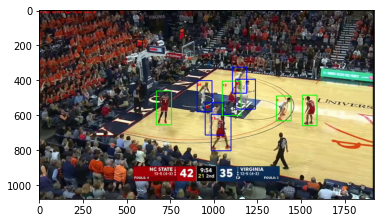

In [28]:
plt.imshow(frame)

colorado - black forma
washington - white form



GROUND TRUTH:
blue  - colorado - 0.0
green - washington - 1.0

PREDICTION:
0.0 - COLORADO
1.0 - WASHINGTON

RESULT:
    TRUE!

In [34]:
!aws s3 cp ./demos/custom_5vals_colors_all_30ep_debug/2020_01-20_NCState_at_Virginia.mp4 s3://boost-operators-data/tracking_results/

upload: demos/custom_5vals_colors_all_30ep_debug/2020_01-20_NCState_at_Virginia.mp4 to s3://boost-operators-data/tracking_results/2020_01-20_NCState_at_Virginia.mp4


In [35]:
!rm ./demos/custom_5vals_colors_all_30ep_debug/2020_01-20_NCState_at_Virginia.mp4

In [23]:
import src._init_paths
import src.lib.datasets.dataset.jde as datasets

In [26]:
input_video = '/media/data_disc/data/videos2/2021_01_20_Colorado_at_Washington/2021_01_20_Colorado_at_Washington.mp4'
dataloader = datasets.LoadVideo(input_video, (1088, 608))

valid_frames = set()
for i in range(len(dataloader)):
    curr_data = ocr['results'][str(i)]

    if curr_data['score_bug_present'] and curr_data['game_clock_running']:

        valid_frames.add(i)

        

Lenth of the video: 172920 frames


In [27]:
results = json.load(open('./demos/custom_5vals_colors_all_30ep_data2_50ep/magazine/2021_01_20_Colorado_at_Washington.json'))

In [46]:
tlwhs = []
for i in range(len(dataloader)):
    if str(i) not in results:
        tlwhs.append([])
    else:
        curr_hist = []
        for x in results[str(i)]:
            line = x.split(',')
            curr_hist.append(line[1:5])
        tlwhs.append(curr_hist) 

In [47]:
tlwhs[871][0]

['0.7506660461425781',
 '0.5294657389322917',
 '196.460205078125',
 '425.45318603515625']

In [32]:
all_hists = []
for i in range(len(dataloader)):
    if str(i) not in results:
        all_hists.append([])
    else:
        curr_hist = []
        for x in results[str(i)]:
            line = x.split(',')
            curr_hist.append(line[-2])
        all_hists.append(curr_hist) 

In [34]:
all_jerseys = []
for i in range(len(dataloader)):
    if str(i) not in results:
        all_jerseys.append([])
    else:
        curr_jer = []
        for x in results[str(i)]:
            line = x.split(',')
            curr_jer.append(line[-1])
            
        all_jerseys.append(curr_jer)

In [30]:
results['871']

['1,0.7506660461425781,0.5294657389322917,196.460205078125,425.45318603515625,0.0,55',
 '2,0.8631458918253581,0.1757689016836661,104.443115234375,270.4006042480469,1.0,None',
 '3,0.40824549992879233,0.46805312545211225,160.6307373046875,401.691650390625,1.0,24',
 '4,0.5262829462687174,0.4294441505714699,148.1846923828125,357.78277587890625,0.0,10',
 '5,0.15809319814046224,0.7213876794885706,184.145263671875,466.08587646484375,0.0,10',
 '6,0.7384349187215169,0.30305766352900754,143.103759765625,306.2678527832031,1.0,None',
 '7,0.36453307469685875,0.4110870361328125,143.248046875,355.74041748046875,0.0,1',
 '8,0.44318790435791017,0.23128238254123265,110.7904052734375,275.8504638671875,1.0,None',
 '9,0.4589625358581543,0.34071923715096936,121.881591796875,308.7441101074219,0.0,None']

In [28]:
output_video = './demos/custom_5vals_colors_all_30ep_data2_50ep/magazine/2021_01_20_Colorado_at_Washington.mp4'

In [97]:
def get_color_team(cls):
    if cls=='0.0':
        return (255,0,0)
    elif cls=='1.0':
        return (0,255,0)
    
    
dataloader.re_init()
valid = 0
frame_id = 0

### Write to video
img_h, img_w = (1080, 1920)
text_scale = max(1, img0.shape[1] / 1600.)
out = cv2.VideoWriter(output_video, cv2.VideoWriter_fourcc(*'MP4V'), dataloader.frame_rate, (img_w, img_h))

jersey = None
ball = None
for i, (path, img, img0) in enumerate(tqdm(dataloader)):
    if valid >= len(results) or i>1000: break
    curr_data = ocr['results'][str(i)]

    if curr_data['score_bug_present'] and curr_data['game_clock_running']:

        if i in valid_frames:
            online_tlwhs = tlwhs[i]
            cls = all_hists[i]
            jersey = all_jerseys[i]

            for ii, tlwh in enumerate(online_tlwhs):
                x1, y1, w, h = [float(x) for x in tlwh]
                intbox = tuple(map(int, (x1*img_w, y1*img_h, (x1*img_w + w), (y1*img_h + h))))
                color = get_color_team(cls[ii])
                cv2.rectangle(img0, intbox[0:2], intbox[2:4], color=color, thickness=1)

                if jersey:
                    jersey_id = str(jersey[ii])
                    cv2.putText(img0, jersey_id, (intbox[0], intbox[1] + 30), cv2.FONT_HERSHEY_PLAIN, text_scale, (0, 0, 255),
                            thickness=1)

        valid += 1
        
    out.write(img0)
    frame_id += 1





out.release()

In [93]:
len(ocr['results'])

172920

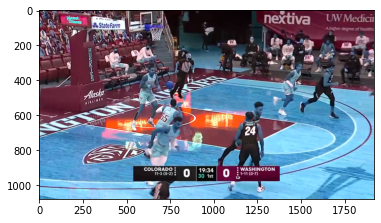

In [84]:
plt.imshow(img0)